In [1]:
import sys, os
from time import time
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from modules.paths import Experiment

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Load paths to each set of experiments
control_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/control/slices/w-eyFLP_PntGFP_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
mutant_path = '/Volumes/bernasek_t5/pnt_manuscript/microscopy/yan_clones/perturbation/slices/w-eyFLP_PntGFP_YanE833_FRT40A_PntGFP_Ubi-mRFPnls_FRT40A'
control = Experiment(control_path)
mutant = Experiment(mutant_path)

In [3]:
# Load individual disc
disc_id = 29
disc = control.discs[disc_id]
stack = disc.load_stack()

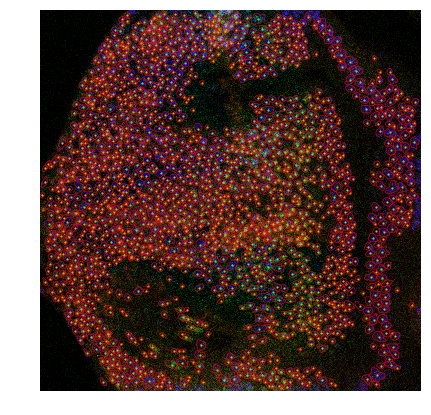

In [5]:
fig = layer.show(figsize=(7, 7), lw=.5)

xy = layer.df[['centroid_y', 'centroid_x']].values
fig.axes[0].scatter(*xy.T, c='y', s=5, lw=0)

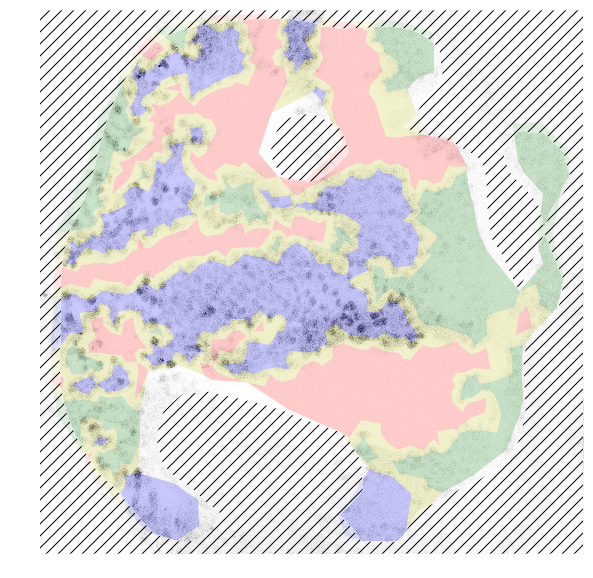

In [28]:
layer.annotate(channel='r', q=98, fg_only=True, upper_bound=90)
fig = layer.plot_annotation()

In [4]:
layer = stack.load_layer(0)

In [9]:
import infomap
import networkx as nx

In [10]:
channel = 'r_normalized'

layer.annotate(q=95, channel=channel, fg_only=False, upper_bound=90)
links = layer.annotation.graph.build_links(channel=channel)

im = layer.annotation.clustering.im.infomap


communities = {}
for node in im.iterLeafNodes():
    communities[node.physicalId] = node.moduleIndex()


# level = 3
# path_to_module = {}
# for m in im.iterModules():
#     if m.depth() == level:
#         path_to_module[m.path()] = m.moduleIndex()    
    
# communities = {}
# for i, node in enumerate(im.iterLeafNodes(1)):
#     if i == 0:
#         continue
#     communities[node.physicalId] = path_to_module[node.path()[:level]]
    
    # doesnt work after depth 1 because top node changes between paths!!

In [13]:
parse_link = lambda x,y,z: (x,y,dict(weight=z))
nx_edges = [parse_link(*link) for link in links]
G = nx.Graph()
G.add_edges_from(nx_edges)
nx.set_node_attributes(G, name='community', values=communities)

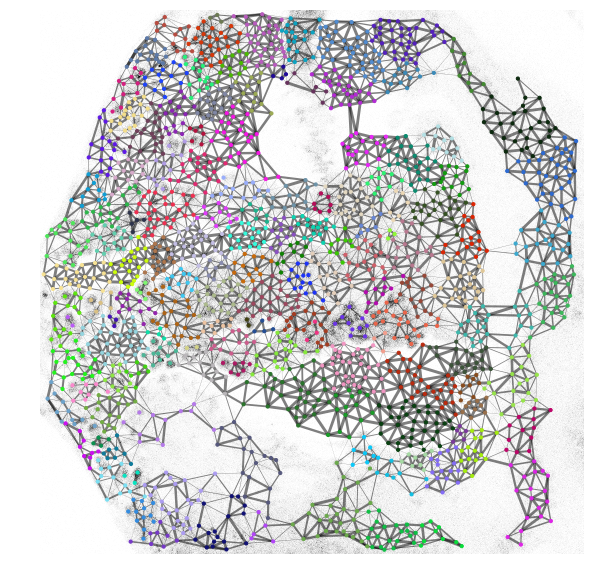

In [18]:
fig = layer.get_channel('r').show(segments=False, cmap=plt.cm.Greys)
pos = get_pos(layer)
_ = drawNetwork(G, pos, ax=fig.axes[0], alpha=1, edge_alpha=0.5, lw=3, node_size=10)

In [12]:
from matplotlib import colors

def get_pos(layer):
    g = layer.annotation.graph
    pos = {}
    for k in g.nodes:
        i = g.position_map(k)
        pos[k] = np.array([g.tri.x[i], g.tri.y[i]])
    return pos

def drawNetwork(G, pos, ax=None, alpha=1, edge_alpha=1, lw=1, node_size=20):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 15))
    
    # position map
    #pos = nx.spring_layout(G, iterations=5)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    
    # color map from http://colorbrewer2.org/
    c = np.random.random(size=(numCommunities, 3))
    cmapLight = colors.ListedColormap(c, 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(c, 'indexed', numCommunities)

    # Draw edges
    weights = [G[u][v]['weight'] for u,v in G.edges]
    norm = colors.Normalize(vmin=min(weights), vmax=max(weights))
    width = [norm(w)*lw for w in weights]
    nx.draw_networkx_edges(G, pos, ax=ax, width=width, alpha=edge_alpha)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        node_size=node_size,
        pos = pos,
        node_color = communities,
        alpha=alpha,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)


    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()
    
    return pos